# WHO COVID-19 data
We will do an EDA for the WHO COVID-19 data. You can take a look at a report in Sep 2020 [weekly WHO COVID-19 update](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200921-weekly-epi-update-6.pdf?sfvrsn=d9cf9496_6&download=true) for reference.


You can use the following code to obtain the Covid-19 data from WHO.
```r
covid <- read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")
```

(a) First, we need to get the meanings of the variables and the values. What do the values in `Who_region` represent? (google to find their meanings) Recode these values. Is there any missing value in the variables? What do they represent?
```r
sum(is.na(covid))
sum(is.na( select(covid, Country_code )))
summary(is.na(covid))

covid %>% filter(is.na(Country_code))
unique(covid$WHO_region)

view(covid %>% 
    filter(WHO_region == "Other") )

covid2 <- covid %>% 
    filter(WHO_region != "Other") %>% 
  mutate(WHO_region = fct_recode(WHO_region,
                                 "Eastern Mediterranean"="EMRO",
                                 "Europe" = "EURO",
                                 "Africa" = "AFRO",
                                 "Western Pacific" = "WPRO",
                                 "Americas"="AMRO",
                                 "South-East Asia" = "SEARO"))

```


In [12]:
covid2 <- covid %>% filter(WHO_region != "Other") %>% 
     mutate(WHO_region = fct_recode(WHO_region,
                                 "Eastern Mediterranean"="EMRO",
                                 "Europe" = "EURO",
                                 "Africa" = "AFRO",
                                 "Western Pacific" = "WPRO",
                                 "Americas"="AMRO",
                                 "South-East Asia" = "SEARO"))

(b) Get some summary statistics from the data. For example, how many countries in each regioin? What is the number of cumulative cases (deaths) in each region?

```r
range(covid2$Date_reported)
unique(covid2$Country)

covid2 %>% count(WHO_region)

covid2 %>% filter(Date_reported == "2021-12-2") %>% 
  count(WHO_region)
```

In [18]:
covid2 %>% filter(Date_reported == "2021-12-2")   %>% 
    count(WHO_region)



WHO_region,n
<fct>,<int>
Africa,50
Americas,56
Eastern Mediterranean,22
Europe,62
South-East Asia,11
Western Pacific,35


```r
### verify if the cumulative cases are corerct
covid3 <- covid2 %>% filter(Date_reported == "2021-11-29") %>% 
  select(Country_code,Country,Cumulative_cases)

covid4 <- covid2 %>% 
group_by(Country_code,Country) %>% 
  summarize(cum_case = sum(New_cases))

covid3 %>% left_join(covid4, by ="Country") %>% 
   mutate(diff = Cumulative_cases-cum_case) %>% 
  filter(diff !=0)
```

In [24]:
covid2 %>% filter( Date_reported <= "2021-12-2",Date_reported > "2021-11-25")  %>% 
    group_by(WHO_region) %>% 
    summarize(cum_case = sum(New_cases))


covid2 %>% filter( Date_reported <= "2021-12-2",Date_reported > "2021-11-25")  %>% 
    group_by(WHO_region) %>% 
    summarize(cum_death = sum(New_deaths))




WHO_region,cum_case
<fct>,<dbl>
Africa,53370
Americas,767914
Eastern Mediterranean,95600
Europe,2708907
South-East Asia,111929
Western Pacific,200264


WHO_region,cum_death
<fct>,<dbl>
Africa,590
Americas,10044
Eastern Mediterranean,1686
Europe,29183
South-East Asia,3306
Western Pacific,3069


```r
#####  cumulative cases in each WHO region

covid2 %>% 
  filter(Date_reported == "2021-12-1") %>% 
  group_by(WHO_region) %>% 
  summarize(region_cum_case = sum(Cumulative_cases))

covid2 %>% 
  filter(Date_reported >= "2021-11-24",Date_reported <= "2021-12-1") %>% 
  group_by(WHO_region) %>% 
  summarize(region_cum_case = sum(New_cases))
```

```r
#### cumulative death in the past week
covid2 %>% 
  filter(Date_reported >= "2021-11-24",Date_reported <= "2021-12-1") %>% 
  group_by(WHO_region) %>% 
  summarize(region_cum_death = sum(New_deaths))
```

WHO_region,region_cum_death
<fct>,<dbl>
Africa,552
Americas,11310
Eastern Mediterranean,2005
Europe,33956
South-East Asia,3784
Western Pacific,3512


(c) One important quesiton is how the number of deaths and cases changes over time. Do some visualization to answer this question. For example, you can draw the time series plot for total number of cases and deaths; you can also do this by region.


```r
p1 <- covid2 %>% 
  group_by(Date_reported) %>% 
  summarize(death = sum(New_deaths),
            cases = sum(New_cases)) %>% 
  ggplot()+
  geom_line(aes(x=Date_reported, y = death))+
  scale_x_date(labels = date_format("%d-%b"),
                 breaks = "1 month")+
  theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())
```

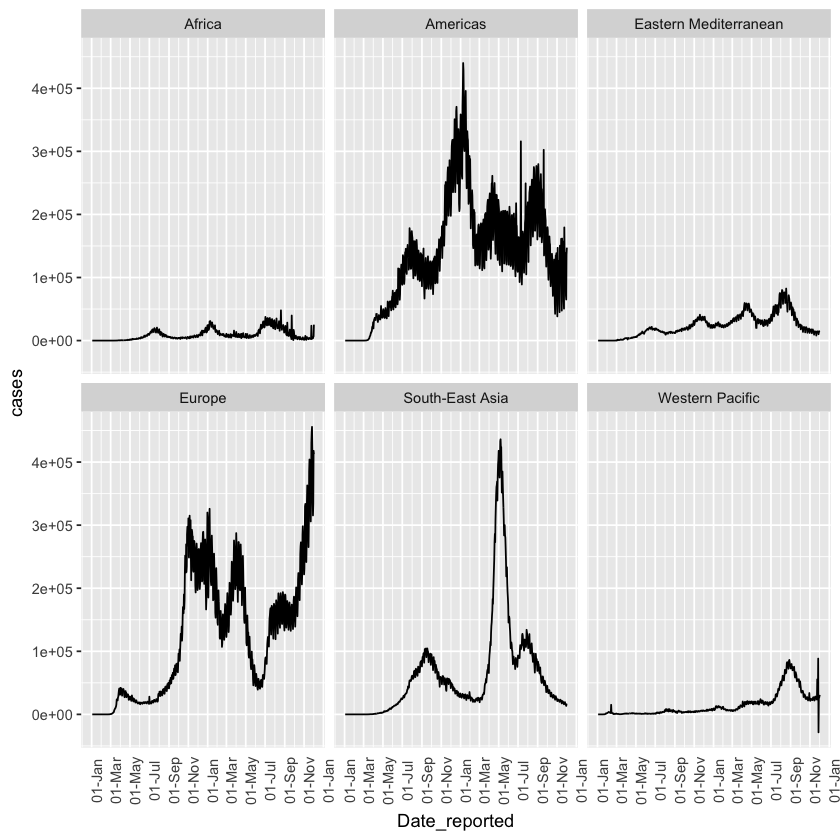

In [31]:
covid2 %>% group_by(Date_reported,WHO_region) %>% 
    summarize(cases = sum(New_cases)) %>% 
    ggplot()+
    geom_line(aes(x= Date_reported, y =cases))+
    scale_x_date(labels = date_format("%d-%b"),breaks = "2 month")+
    theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())+
    facet_wrap(~WHO_region)

```r
p2 <- covid2 %>% 
  group_by(Date_reported) %>% 
  summarize(death = sum(New_deaths),
            cases = sum(New_cases)
            )  %>% 
  mutate(week = floor_date(Date_reported, "week")) %>% 
    group_by(week) %>%
    summarize(weekly_cases=sum(cases)) %>% 
  ggplot()+
  geom_col(aes(week,weekly_cases),fill="steelblue")+ 
  scale_x_date(labels = date_format("%d-%b"),
                 breaks = "3 weeks")+
  theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())
```

```{r}
gridExtra::grid.arrange(p1, p2, nrow=1, ncol=2)
```

```r
covid2 %>% 
  group_by(Date_reported,WHO_region) %>% 
  summarize(death = sum(New_deaths),
            cases = sum(New_cases)) %>% 
  ggplot()+
  geom_line(aes(x=Date_reported, y = death))+
  scale_x_date(labels = date_format("%d-%b"),
                 breaks = "1 month")+
  theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())+
  facet_wrap(~WHO_region,scales = "free_y")
```

```r
covid2 %>% 
  group_by(Date_reported,WHO_region) %>% 
  summarize(death = sum(New_deaths),
            cases = sum(New_cases))  %>% 
    group_by(week=floor_date(Date_reported, "month"),WHO_region) %>%
    summarize(weekly_cases=sum(cases)) %>% 
  ggplot()+
  geom_col(aes(week,weekly_cases),fill="steelblue")+ 
  scale_x_date(labels = date_format("%d-%b"),
                 breaks = "2 months")+
  theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())+
  facet_wrap(~WHO_region,scales = "free_y")
```

```r
covid2 %>% 
  group_by(Date_reported,WHO_region) %>% 
  summarize(death = sum(New_deaths),
            cases = sum(New_cases))  %>% 
    group_by(week=floor_date(Date_reported, "week"),WHO_region) %>%
    summarize(weekly_cases=sum(cases)) %>% 
  ggplot()+
  geom_col(aes(week,weekly_cases,fill=WHO_region))+ 
  scale_x_date(labels = date_format("%d-%b"),
                 breaks = "1 month")+
  theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())
```

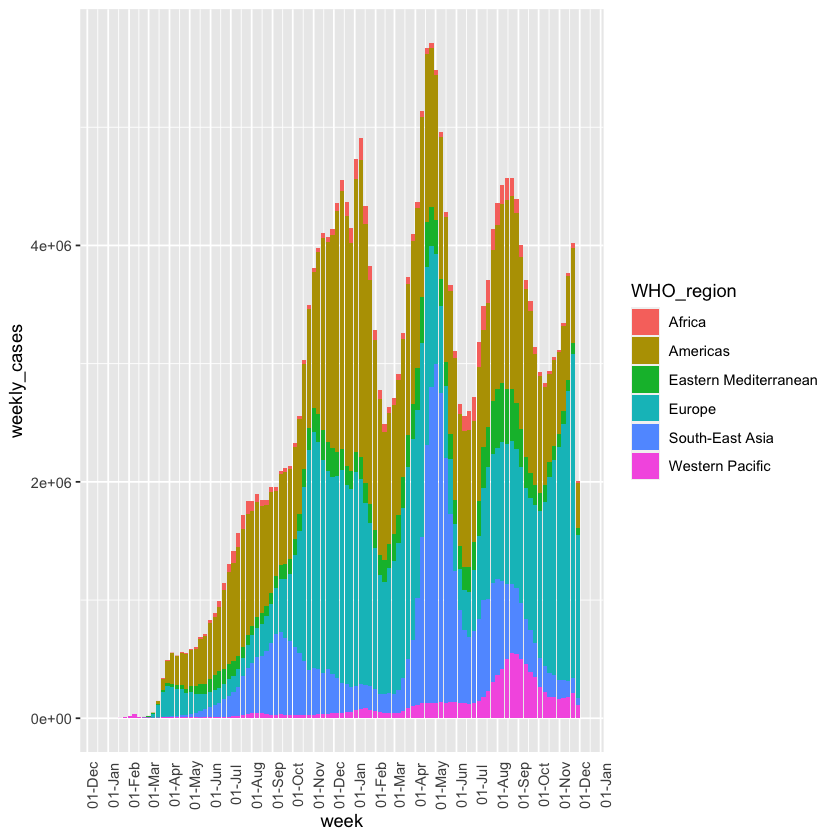

In [37]:
covid2 %>% 
  group_by(Date_reported,WHO_region) %>% 
  summarize(death = sum(New_deaths),
            cases = sum(New_cases))  %>% 
    group_by(week=floor_date(Date_reported, "week"),WHO_region) %>%
    summarize(weekly_cases=sum(cases)) %>% 
  ggplot()+
  geom_col(aes(week,weekly_cases,fill=WHO_region))+ 
  scale_x_date(labels = date_format("%d-%b"),
                 breaks = "1 month")+
  theme(axis.text.x = element_text(angle = 90), axis.ticks.x=element_blank())